In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils import shuffle
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

# Attribute Information:

data_info = pd.read_csv("/content/drive/My Drive/Data/NUSW-NB15_features.csv", encoding = "ISO-8859-1")

In [0]:

# Retrieve Attribute Names

column_attributes = list (data_info['Name'])

In [0]:
# Read the data available in 4 csv files using temporary data frames

dataframe1 = pd.read_csv("/content/drive/My Drive/Data/UNSW-NB15_1.csv",low_memory=False, header=None)
dataframe2 = pd.read_csv("/content/drive/My Drive/Data/UNSW-NB15_2.csv", low_memory=False, header=None)
dataframe3 = pd.read_csv("/content/drive/My Drive/Data/UNSW-NB15_3.csv", low_memory=False, header=None)
dataframe4 = pd.read_csv("/content/drive/My Drive/Data/UNSW-NB15_4.csv",low_memory=False, header=None)

In [0]:
# Name the columns of all data frames using attribute names from features.csv

df_list = [dataframe1,dataframe2,dataframe3,dataframe4]
for df in df_list:
    name = [v.lower() for k, v in enumerate(column_attributes)]
    df.columns = name

In [9]:
# Concatenate the 4 temporary data frames into one single data frame

dataset = pd.concat([dataframe1, dataframe2, dataframe3, dataframe4])
dataset.shape

(2540047, 49)

In [0]:

# Delete temporary data frames

del dataframe1
del dataframe2
del dataframe3
del dataframe4

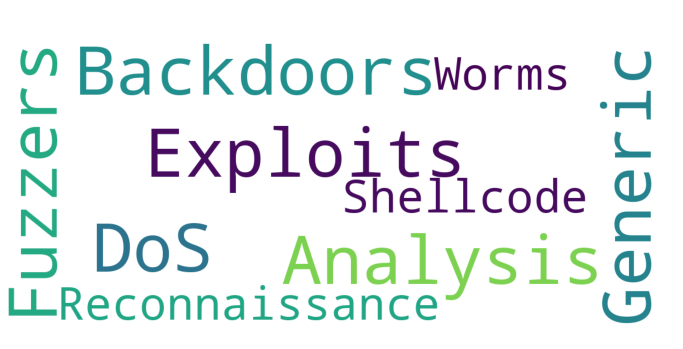

In [11]:
# Function to show the different attack cateegories present in the dataset

stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):

    attack_catgs = data.loc[:,'attack_cat'].replace('Backdoor','Backdoors', regex=False)
    attack_catgs = attack_catgs.dropna().to_numpy()
    attack_catgs = [x.strip(' ') for x in attack_catgs]
    attack_catgs = np.unique(attack_catgs)
    text = " ".join(str(item) for item in attack_catgs)
    wordcloud = WordCloud(
        background_color='white',
        collocations=False,
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(text)
 
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(dataset)

In [0]:
# Plot to show the distribution of all attack categories

def plot_attack_category(data):
    attack_catgs = data.loc[:,'attack_cat'].replace('Backdoor','Backdoors', regex=False)
    attack_catgs = attack_catgs.dropna().to_numpy()
    attack_catgs = [x.strip(' ') for x in attack_catgs]
    sns.set(rc={'figure.figsize':(15,10),"font.size":70,"axes.titlesize":40,"axes.labelsize":20},style="white")
    catg_plot = sns.countplot(attack_catgs,data = data)
    for p in catg_plot.patches:
      height = p.get_height()
      catg_plot.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center",fontsize = 15)
    


In [13]:
# Provided data is not consistent. Check and make relevant changes

columns_with_space = dataset.columns[dataset.isin([' ']).any()].tolist()
print('columns_with_space ',columns_with_space)
columns_with_null = dataset.columns[dataset.isna().any()].tolist()
print('columns_with_null ', columns_with_null)
columns_with_dash = dataset.columns[dataset.isin(['-']).any()].tolist()
print('columns_with_dash', columns_with_dash)

columns_with_space  ['ct_ftp_cmd']
columns_with_null  ['ct_flw_http_mthd', 'is_ftp_login', 'attack_cat']
columns_with_dash ['sport', 'dsport', 'service']


In [0]:

# Handle null and '-' values

# Where attack_cat not mentioned, replace with 'Normal'
dataset.loc[:,'attack_cat'] = dataset.loc[:,'attack_cat'].replace(np.nan,'Normal', regex=True)

dataset.loc[:,'ct_flw_http_mthd'] = dataset.loc[:,'ct_flw_http_mthd'].replace(np.nan,0, regex=True)
dataset.loc[:,'is_ftp_login'] = dataset.loc[:,'is_ftp_login'].replace(np.nan,0, regex=True)

dataset.loc[:,'ct_ftp_cmd'] = dataset.loc[:,'ct_ftp_cmd'].replace(' ',0, regex=True)

dataset.loc[:,'sport'] = dataset.loc[:,'sport'].replace('-',0, regex=False)
dataset.loc[:,'dsport'] = dataset.loc[:,'dsport'].replace('-',0, regex=False)
dataset.loc[:,'service'] = dataset.loc[:,'service'].replace('-','Others', regex=False)

dataset.loc[:,'attack_cat'] = dataset.loc[:,'attack_cat'].replace('Backdoor','Backdoors', regex=False)

In [15]:
# Columns that have String values

categorical_values = dataset.select_dtypes(exclude=['number']).keys()
print('categorical_values ', categorical_values)

categorical_values  Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service',
       'ct_ftp_cmd', 'attack_cat'],
      dtype='object')


In [16]:
# ct_ftp_cmd field has erroneous String values, such as '0' instead of 0. Handle those values

arrg = dataset.loc[:, 'ct_ftp_cmd'].astype('str')
dataset.loc[:, 'ct_ftp_cmd'] = pd.to_numeric(arrg, errors='coerce').fillna(0).astype(np.int32)
print(dataset.loc[:, 'ct_ftp_cmd'].unique())
print('ct_ftp_cmd', dataset.loc[:, 'ct_ftp_cmd'].dtypes)

[0 1 6 2 4 8 5 3]
ct_ftp_cmd int32


In [0]:

# Label Encoding for categorical values. Can't do one hot encoding as it will result in huge increase in column size.

dataset.loc[:,'srcip'] = dataset.loc[:,'srcip'].astype('category')
# Assigning numerical values
dataset.loc[:,'srcip'] = dataset.loc[:,'srcip'].cat.codes

dataset.loc[:,'sport'] = dataset.loc[:,'sport'].astype('category')
# Assigning numerical values 
dataset.loc[:,'sport'] = dataset.loc[:,'sport'].cat.codes

dataset.loc[:,'dstip'] = dataset.loc[:,'dstip'].astype('category')
# Assigning numerical values
dataset.loc[:,'dstip'] = dataset.loc[:,'dstip'].cat.codes

dataset.loc[:,'dsport'] = dataset.loc[:,'dsport'].astype('category')
# Assigning numerical values
dataset.loc[:,'dsport'] = dataset.loc[:,'dsport'].cat.codes

In [18]:
# Print dataframe after label encoding

dataset[0:5]

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,ltime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,33,68854,24,47344,udp,CON,0.001055,132,164,31,29,0,0,dns,500473.93750,621800.93750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,3,7,1,3,1,1,1,Normal,0
1,33,90600,27,253,udp,CON,0.036133,528,304,31,29,0,0,Others,87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.89101,10.682733,1421927414,1421927414,7.005,7.564333,0.0,0.0,0.0,0,0,0.0,0.0,0,2,4,2,3,1,1,2,Normal,0
2,39,69669,25,47344,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.53130,636282.37500,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,12,8,1,2,2,1,1,Normal,0
3,38,93095,23,47344,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.56250,542597.18750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.043,0.014000,0.0,0.0,0.0,0,0,0.0,0.0,0,6,9,1,1,1,1,1,Normal,0
4,36,108205,8,47344,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.25000,609067.56250,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.005,0.003000,0.0,0.0,0.0,0,0,0.0,0.0,0,7,9,1,1,1,1,1,Normal,0


In [19]:
# Store input columns in X

X = dataset.iloc[:,0:47]
print(X[0:5])

   srcip   sport  dstip  ...  ct_src_dport_ltm ct_dst_sport_ltm ct_dst_src_ltm
0     33   68854     24  ...                 1                1              1
1     33   90600     27  ...                 1                1              2
2     39   69669     25  ...                 2                1              1
3     38   93095     23  ...                 1                1              1
4     36  108205      8  ...                 1                1              1

[5 rows x 47 columns]


In [20]:
# Store output columns in Y

Y = dataset.iloc[:,-2:]
print(Y[0:5])

  attack_cat  label
0     Normal      0
1     Normal      0
2     Normal      0
3     Normal      0
4     Normal      0


In [21]:
dataset.loc[:,'proto'] = dataset.loc[:,'proto'].astype('category')
dataset.loc[:,'proto'] = dataset.loc[:,'proto'].cat.codes
dataset.loc[:,'state'] = dataset.loc[:,'state'].astype('category')
dataset.loc[:,'state'] = dataset.loc[:,'state'].cat.codes
dataset.loc[:,'service'] = dataset.loc[:,'service'].astype('category')
dataset.loc[:,'service'] = dataset.loc[:,'service'].cat.codes
X = dataset.iloc[:,0:47]
print('Data After one hot encoding\n', X[0:5])

Data After one hot encoding
    srcip   sport  dstip  ...  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm
0     33   68854     24  ...                 1                 1               1
1     33   90600     27  ...                 1                 1               2
2     39   69669     25  ...                 2                 1               1
3     38   93095     23  ...                 1                 1               1
4     36  108205      8  ...                 1                 1               1

[5 rows x 47 columns]


In [22]:
'''
# One Hot Encoding of output column 'attack_cat'
Y.loc[:,'attack_cat'] = [i.strip(' ') for i in Y.loc[:,'attack_cat']]
print('attack cat ', (Y.loc[:,'attack_cat'].unique()))
Y_enc = pd.get_dummies(Y, columns=['attack_cat'])
'''

"\n# One Hot Encoding of output column 'attack_cat'\nY.loc[:,'attack_cat'] = [i.strip(' ') for i in Y.loc[:,'attack_cat']]\nprint('attack cat ', (Y.loc[:,'attack_cat'].unique()))\nY_enc = pd.get_dummies(Y, columns=['attack_cat'])\n"

In [0]:
# Normalization

from scipy import stats
from sklearn.preprocessing import MinMaxScaler
# Pass parameter type = 'statistical' or 'minmax'
# Note: statistical is better for SVM and KNN.
def normalization(data, type='minmax'):
    if type == 'statistical':
        return stats.zscore(data)
    elif type == 'minmax':
        scaler = MinMaxScaler()
        return scaler.fit_transform(data)
    else:
        print('\n Norm type not found! \n')

In [0]:

X = normalization(X, 'minmax')
# print(X[0:5])

In [0]:
# from sklearn.ensemble.forest import RandomForestClassifier
# from sklearn.feature_selection import SelectFromModel

In [26]:
# One Hot Encoding of output column 'attack_cat'

Y.loc[:,'attack_cat'] = [i.strip(' ') for i in Y.loc[:,'attack_cat']]
print('attack cat ', (Y.loc[:,'attack_cat'].unique()))

encoding = { 'attack_cat':{'Normal':0, 'Exploits':1, 'Reconnaissance':2, 'DoS':3, 'Generic':4,
       'Shellcode':5, 'Fuzzers':6, 'Worms':7, 'Backdoors':8, 'Analysis':9}}
Y.replace(encoding, inplace=True)

attack cat  ['Normal' 'Exploits' 'Reconnaissance' 'DoS' 'Generic' 'Shellcode'
 'Fuzzers' 'Worms' 'Backdoors' 'Analysis']


In [27]:
Y['attack_cat']
y_cat=[]
y_cat = np.array(Y['attack_cat']).reshape(-1,1)
y_cat

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [28]:
clf = ExtraTreesClassifier(n_estimators=500)
clf = clf.fit(X, y_cat)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [0]:
# sel = (RandomForestClassifier(n_estimators = 100))
# sel.fit(X, y_cat)

In [30]:
features=[]
print(clf.feature_importances_)
features=(clf.feature_importances_).tolist()

[5.36519805e-02 1.19805734e-02 4.82151826e-02 3.57791566e-02
 5.96293981e-03 1.63632797e-02 2.81228489e-03 1.50850229e-02
 3.18191979e-03 2.55999154e-01 5.17981749e-02 2.24190453e-03
 2.45028221e-03 2.21085897e-02 7.91117196e-03 5.73139640e-03
 2.08482986e-03 2.85039236e-03 2.17798757e-02 1.76483576e-02
 6.05858060e-03 5.35377960e-03 2.91246050e-02 1.70920800e-02
 9.64579963e-04 7.21495343e-04 2.52322864e-03 2.13860604e-03
 1.45451717e-02 1.66872320e-02 3.36445289e-03 2.22917309e-03
 4.18175893e-03 3.80414419e-03 3.53820475e-03 4.99128496e-04
 1.43363452e-01 8.70277929e-04 2.28225558e-04 1.81609970e-04
 2.29943056e-02 2.76430112e-02 1.47994450e-02 1.48350139e-02
 2.32660502e-02 2.44949040e-02 2.88610147e-02]


In [31]:
print("Features sorted by their score:")
feature_imp = sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), column_attributes), 
             reverse=True)
print(feature_imp)
low_variance_cols = [x[0] for x in feature_imp if x[0] < 0.002]

Features sorted by their score:
[(0.256, 'sttl'), (0.1434, 'ct_state_ttl'), (0.0537, 'srcip'), (0.0518, 'dttl'), (0.0482, 'dstip'), (0.0358, 'dsport'), (0.0291, 'smeansz'), (0.0289, 'ct_dst_src_ltm'), (0.0276, 'ct_srv_dst'), (0.0245, 'ct_dst_sport_ltm'), (0.0233, 'ct_src_dport_ltm'), (0.023, 'ct_srv_src'), (0.0221, 'service'), (0.0218, 'swin'), (0.0176, 'dwin'), (0.0171, 'dmeansz'), (0.0167, 'Ltime'), (0.0164, 'state'), (0.0151, 'sbytes'), (0.0148, 'ct_src_ ltm'), (0.0148, 'ct_dst_ltm'), (0.0145, 'Stime'), (0.012, 'sport'), (0.0079, 'Sload'), (0.0061, 'stcpb'), (0.006, 'proto'), (0.0057, 'Dload'), (0.0054, 'dtcpb'), (0.0042, 'tcprtt'), (0.0038, 'synack'), (0.0035, 'ackdat'), (0.0034, 'Sintpkt'), (0.0032, 'dbytes'), (0.0029, 'Dpkts'), (0.0028, 'dur'), (0.0025, 'dloss'), (0.0025, 'Sjit'), (0.0022, 'sloss'), (0.0022, 'Dintpkt'), (0.0021, 'Spkts'), (0.0021, 'Djit'), (0.001, 'trans_depth'), (0.0009, 'ct_flw_http_mthd'), (0.0007, 'res_bdy_len'), (0.0005, 'is_sm_ips_ports'), (0.0002, 'is_ftp_

In [32]:
#selecting features
sfm = SelectFromModel(clf, threshold=0.002)
sfm.fit(X,y_cat)
X= sfm.transform(X)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


In [33]:
X.shape

(2540047, 41)

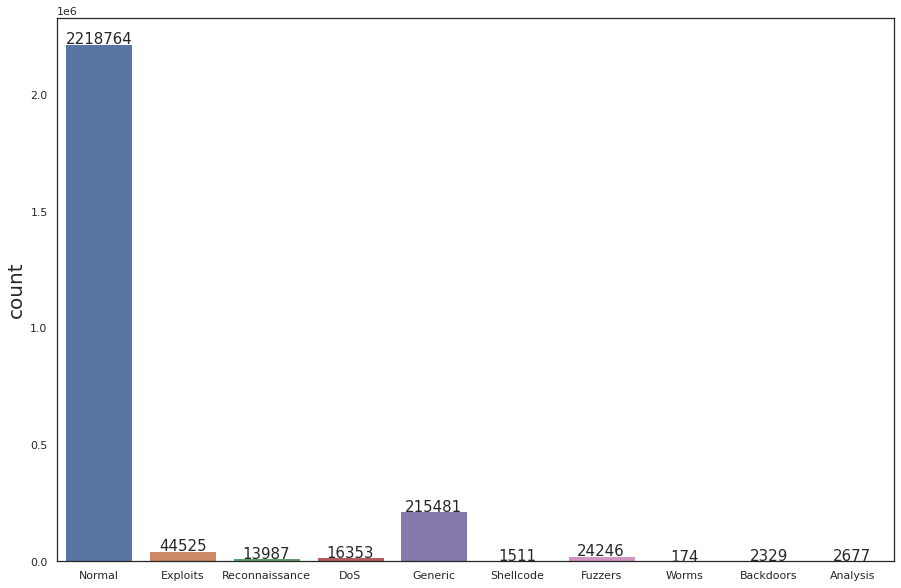

In [34]:
plot_attack_category(dataset)

In [35]:
Counter(Y['attack_cat'])

Counter({0: 2218764,
         1: 44525,
         2: 13987,
         3: 16353,
         4: 215481,
         5: 1511,
         6: 24246,
         7: 174,
         8: 2329,
         9: 2677})

In [0]:
# Retrive all Normal and Generic row data and convert as list

filter_list = [(x,y) for (x,y) in zip(X,Y['attack_cat'])if (y ==0 or y== 4)]
x = []
y = []
for i , val in enumerate(filter_list):
  x.append(val[0])
  y.append(val[1])

In [37]:
# Undersample Normal and Generic class instances 

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(x, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 215481, 4: 215481})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
# Retrive all other rows except Normal and Generic row data and convert as list

filter_other_cat = [(x,y) for (x,y) in zip(X,Y['attack_cat'])if (y !=0 and y!= 4)]
x_other = []
y_other = []
for i , val in enumerate(filter_other_cat):
  x_other.append(val[0])
  y_other.append(val[1])

In [0]:
dataset_1 = pd.DataFrame(X_res)

In [0]:
dataset_1['attack_cat'] = y_res

In [0]:
dataset_2 = pd.DataFrame(x_other)


In [0]:
dataset_2['attack_cat'] = y_other

In [0]:
dataset_merged = pd.concat([dataset_1, dataset_2])

In [44]:
dataset_merged.shape

(536764, 42)

In [0]:
dataset = shuffle(dataset_merged).reset_index(drop=True)

In [0]:
# Define class instance ratio to oversample all other class labels

sm = SMOTE(ratio = {0:216000, 4:216000, 1:100000, 6:90000, 3:80000, 2:70000, 9:50000, 8:45000, 5:40000,7:40000 },random_state=42,k_neighbors=5)

In [47]:
X_sm, Y_sm = sm.fit_sample(dataset.iloc[:,0:37],dataset.iloc[:,-1])
print("After balancing the samples among class lables: ",Counter(Y_sm))

/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (216000) in class 0 will be larger than the number of samples in the majority class (class #0 -> 215481)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (216000) in class 4 will be larger than the number of samples in the majority class (class #0 -> 215481)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, catego

After balancing the samples among class lables:  Counter({0: 216000, 4: 216000, 1: 100000, 6: 90000, 3: 80000, 2: 70000, 9: 50000, 8: 45000, 5: 40000, 7: 40000})


In [48]:
dataset.loc[dataset['attack_cat']==0,'label'] = str(0)
dataset.loc[dataset['attack_cat']!=0,'label'] = str(1)
dataset[0:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,attack_cat,label
0,0.952381,0.051796,0.565217,0.681211,0.850746,0.333333,5.277332e-06,0.000022,0.000128,0.121569,0.114173,0.000188,0.000363,0.333333,0.000008,0.002203,0.000564,0.000726,1.0,1.0,0.707004,0.210836,0.035239,0.156667,0.000433,0.000020,0.989896,0.989896,1.091791e-04,1.102649e-04,0.000059,0.000100,0.000025,0.000000,0.030303,0.030303,0.045455,0.106061,0.000000,0.000000,0.060606,0,0
1,0.833333,0.846587,0.586957,0.732550,0.895522,0.133333,1.066392e-07,0.000010,0.000012,0.121569,0.114173,0.000000,0.000000,0.166667,0.000104,0.005901,0.000188,0.000182,0.0,0.0,0.000000,0.000000,0.048537,0.059333,0.000000,0.000000,0.011203,0.011187,5.926172e-08,6.724348e-08,0.000000,0.000000,0.000000,0.000000,0.060606,0.030303,0.060606,0.030303,0.015152,0.000000,0.000000,0,0
2,0.738095,0.000697,0.391304,0.732550,0.895522,0.400000,5.690459e-10,0.000008,0.000000,0.996078,0.000000,0.000000,0.000000,0.166667,0.015230,0.000000,0.000188,0.000000,0.0,0.0,0.000000,0.000000,0.037899,0.000000,0.000000,0.000000,0.987466,0.987465,5.926172e-08,0.000000e+00,0.000000,0.000000,0.000000,0.333333,0.560606,0.560606,0.318182,0.333333,0.318182,0.355932,0.560606,4,1
3,0.714286,0.186072,0.304348,0.123149,0.850746,0.333333,4.745410e-05,0.000053,0.000018,0.996078,0.992126,0.000376,0.000182,0.000000,0.000002,0.000033,0.000939,0.000545,1.0,1.0,0.447405,0.405070,0.050532,0.030000,0.001523,0.000121,0.984519,0.984518,5.053866e-04,1.229883e-03,0.011519,0.011306,0.011695,0.166667,0.030303,0.030303,0.015152,0.000000,0.000000,0.000000,0.030303,6,1
4,0.666667,0.717074,0.217391,0.968698,0.850746,0.333333,1.155390e-04,0.003559,0.000036,0.996078,0.992126,0.003760,0.000182,0.416667,0.000066,0.000030,0.004321,0.001089,1.0,1.0,0.737193,0.395487,0.738697,0.029333,0.001512,0.000165,0.001418,0.001403,2.671603e-04,1.497632e-03,0.008664,0.007785,0.009385,0.166667,0.015152,0.015152,0.000000,0.000000,0.000000,0.000000,0.000000,6,1


In [0]:
col_names = column_attributes
low_variance_cols = ['trans_depth','ct_flw_http_mthd','res_bdy_len','is_sm_ips_ports','is_ftp_login','ct_ftp_cmd']
for val in low_variance_cols:
  col_names.remove(val)

name = [v.lower() for k, v in enumerate(col_names)]
dataset.columns = name

In [0]:
dataset.to_csv('final_dataset.csv')

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [0]:
dataset1 = pd.read_csv('final_dataset.csv')

In [0]:
X=[]
y=[]
X = dataset1.iloc[:,:-2].to_numpy()
y = dataset1.iloc[:,-2].to_numpy()

In [54]:
import time
time_ =[]
skf = StratifiedKFold(n_splits=5,shuffle = True)
f1score = []


# Training Model with Navie Bayes :


for train_index, test_index in skf.split(X, y):
     print("TRAIN:", train_index, "TEST:", test_index)

     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     
     s = time.clock()
     NB_model = GaussianNB()
     NB_model.fit(X_train,y_train)
     y_pred = NB_model.predict(X_test)

     e = time.clock() - s
     time_.append(e) 
     score = f1_score(y_test,y_pred, average='micro')
     f1score.append(score)
     print("Time taken by NB Gaussian means model: ", e,"seconds \n")
     print("F1 score for iteration: ",score,'\n')
print("F1 score for NB Gaussian model prediction: ",f1score,'\n')

TRAIN: [     0      1      3 ... 536758 536759 536763] TEST: [     2      4      8 ... 536760 536761 536762]
Time taken by NB Gaussian means model:  0.6700289999998859 seconds 

F1 score for iteration:  0.7082801598464877 

TRAIN: [     0      1      2 ... 536761 536762 536763] TEST: [     5      7     13 ... 536744 536748 536750]
Time taken by NB Gaussian means model:  0.6444360000000415 seconds 

F1 score for iteration:  0.7098078302422849 

TRAIN: [     0      1      2 ... 536761 536762 536763] TEST: [    11     16     18 ... 536754 536757 536759]
Time taken by NB Gaussian means model:  0.5677410000002965 seconds 

F1 score for iteration:  0.7080845435153187 

TRAIN: [     1      2      4 ... 536760 536761 536762] TEST: [     0      3      6 ... 536741 536758 536763]
Time taken by NB Gaussian means model:  0.5760869999999159 seconds 

F1 score for iteration:  0.710152487587678 

TRAIN: [     0      2      3 ... 536761 536762 536763] TEST: [     1      9     19 ... 536746 536749 5367

In [55]:
# Training Model with KMeans :
Kmean_score = []
time_K = []

for train_index, test_index in skf.split(X, y):
     print("TRAIN:", train_index, "TEST:", test_index)

     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     
     s = time.clock()


     KMeans_model = KMeans(n_clusters=10, random_state=0)
     KMeans_model.fit(X_train,y_train)

     y_pred = KMeans_model.predict(X_test)

     e = time.clock() - s
     time_K.append(e) 
     score = f1_score(y_test,y_pred, average='micro')
     Kmean_score.append(score)
     print("Time taken by KMeans model: ", e,"seconds \n")
     print("F1 score :", score,'\n')
print("F1 score for KMeans  model prediction: ",Kmean_score,'\n')

TRAIN: [     0      1      2 ... 536757 536758 536763] TEST: [     3     12     14 ... 536760 536761 536762]
Time taken by KMeans model:  52.71412800000007 seconds 

F1 score : 0.09941035648747588 

TRAIN: [     1      2      3 ... 536760 536761 536762] TEST: [     0     16     18 ... 536754 536757 536763]
Time taken by KMeans model:  51.837136999999984 seconds 

F1 score : 0.0989818635715816 

TRAIN: [     0      1      2 ... 536761 536762 536763] TEST: [     6      9     10 ... 536729 536747 536750]
Time taken by KMeans model:  50.378369999999904 seconds 

F1 score : 0.1001462464952074 

TRAIN: [     0      1      2 ... 536761 536762 536763] TEST: [     5      8     11 ... 536743 536744 536745]
Time taken by KMeans model:  51.32381399999986 seconds 

F1 score : 0.09958734269186702 

TRAIN: [     0      3      5 ... 536761 536762 536763] TEST: [     1      2      4 ... 536753 536756 536758]
Time taken by KMeans model:  53.65347900000006 seconds 

F1 score : 0.09954169461211716 

F1 sc

In [56]:
# Training Model with Adaboost Classifier :
ada_score = []
time_ada = []
for train_index, test_index in skf.split(X, y):
     print("TRAIN:", train_index, "TEST:", test_index)

     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     
     s = time.clock()


     ada_model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(min_samples_split=4,random_state=21),n_estimators=100)
     ada_model.fit(X_train,y_train)

     y_pred = ada_model.predict(X_test)

     e = time.clock() - s
     time_ada.append(e) 
     score = f1_score(y_test,y_pred, average='micro')
     ada_score.append(score)
     print("Time taken by Ada model: ", e,"seconds \n")
     print("F1 score at iterartion : ",score,'\n')

print("F1 score for Adaboost model prediction: ",ada_score,'\n')

TRAIN: [     0      1      2 ... 536759 536761 536763] TEST: [     5      6      7 ... 536745 536760 536762]
Time taken by Ada model:  1333.8888630000001 seconds 

F1 score at iterartion :  0.9258055201065644 

TRAIN: [     0      1      2 ... 536761 536762 536763] TEST: [     3      8     12 ... 536756 536757 536758]
Time taken by Ada model:  1368.213765 seconds 

F1 score at iterartion :  0.9262899034027926 

TRAIN: [     2      3      4 ... 536759 536760 536762] TEST: [     0      1     10 ... 536753 536761 536763]
Time taken by Ada model:  1359.6082379999998 seconds 

F1 score at iterartion :  0.926848807206133 

TRAIN: [     0      1      2 ... 536761 536762 536763] TEST: [     4      9     14 ... 536721 536750 536755]
Time taken by Ada model:  1383.5359020000005 seconds 

F1 score at iterartion :  0.926764971635632 

TRAIN: [     0      1      3 ... 536761 536762 536763] TEST: [     2     11     16 ... 536744 536748 536759]
Time taken by Ada model:  1394.7943849999992 seconds 

F

In [57]:
# Training Model with xgboost classifier :
xg_score = []
xg_time = []

for train_index, test_index in skf.split(X, y):
     print("TRAIN:", train_index, "TEST:", test_index)

     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     
     s = time.clock()


     XGB_model = XGBClassifier(learning_rate =0.1, n_estimators=100, num_class = 12,
                             min_child_weight=1, gamma=0,subsample=0.8,colsample_bytree=0.8,
                             objective= 'multi:softmax', nthread=4,scale_pos_weight=1,
                             seed=27, early_stopping_rounds=70, verbose=False)

     XGB_model.fit(X_train,y_train)

     y_pred = XGB_model.predict(X_test)

     e = time.clock() - s
     xg_time.append(e) 
     score = f1_score(y_test,y_pred, average='micro')
     xg_score.append(score)
     print("Time taken by xgboost model: ", e,"seconds \n")
     print("F1 score at each iteration: ",score,'\n')
print("F1 score for xgboost  model prediction: ",xg_score,'\n')

TRAIN: [     0      2      4 ... 536761 536762 536763] TEST: [     1      3      6 ... 536751 536755 536756]
Time taken by xgboost model:  1046.3967300000004 seconds 

F1 score at each iteration:  0.9300625040753402 

TRAIN: [     0      1      2 ... 536761 536762 536763] TEST: [    13     17     21 ... 536740 536742 536760]
Time taken by xgboost model:  1066.9079230000007 seconds 

F1 score at each iteration:  0.9302674354698983 

TRAIN: [     0      1      3 ... 536758 536760 536761] TEST: [     2      7     11 ... 536759 536762 536763]
Time taken by xgboost model:  1036.8182899999993 seconds 

F1 score at each iteration:  0.9304257915475115 

TRAIN: [     1      2      3 ... 536760 536762 536763] TEST: [     0      8     10 ... 536749 536754 536761]
Time taken by xgboost model:  1041.516696999999 seconds 

F1 score at each iteration:  0.929801682300448 

TRAIN: [     0      1      2 ... 536761 536762 536763] TEST: [     4      5     12 ... 536744 536746 536758]
Time taken by xgboost

In [0]:
f1 = []
f1.append(f1score)
f1.append(Kmean_score)
f1.append(ada_score)
f1.append(xg_score)

In [0]:
time = []
time.append(time_)
time.append(time_K)
time.append(time_ada)
time.append(xg_time)

In [0]:
def plot_F1score_metrics(title_,xlabel_,ylabel_,list_,l1,l2,l3,l4):
    matplotlib.rc('figure', figsize=(13, 5))

    plt.title(title_)
    plt.xlabel(xlabel_)
    plt.ylabel(ylabel_)
    plt.plot(list_[0],'y',list_[1], 'r',list_[2],'g' ,list_[3],'b',markersize=15)
    [a,b,c,d] = plt.plot(list_[0],'yo',list_[1], 'ro',list_[2],'go',list_[3],'bo',markersize=10)
    plt.legend([a,b,c,d], [l1,l2,l3,l4], loc=9,prop={'size': 12})
    plt.show()

In [0]:
import matplotlib

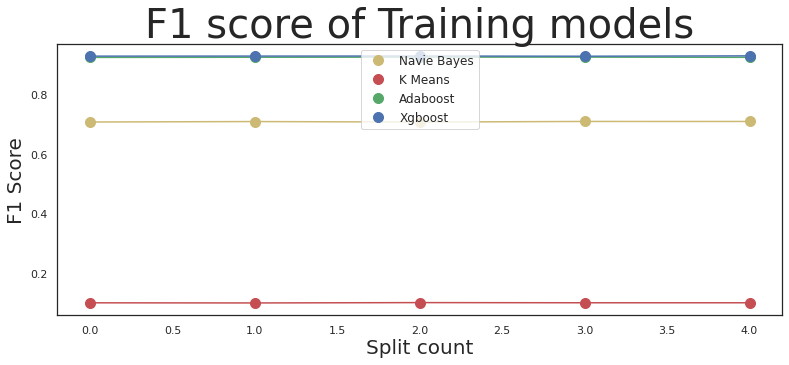

In [62]:
plot_F1score_metrics('F1 score of Training models','Split count','F1 Score',f1,"Navie Bayes","K Means","Adaboost","Xgboost")

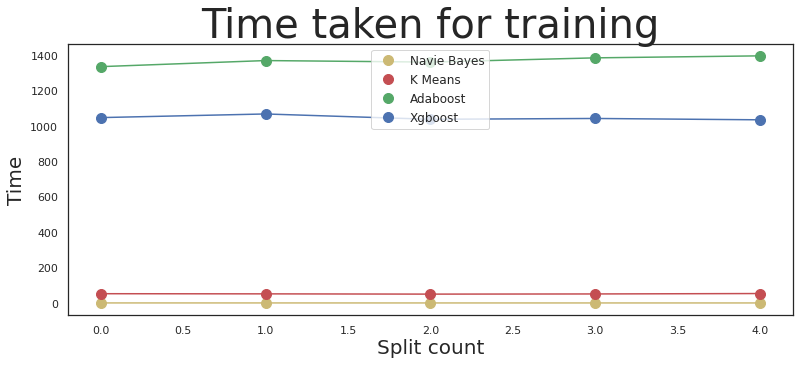

In [64]:
plot_F1score_metrics('Time taken for training','Split count','Time',time,"Navie Bayes","K Means","Adaboost","Xgboost")